# Import Dataset directly from Kaggle using API Key

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"binodtandan","key":"1db3b2a8c464380e91fc6db8243886a8"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset
License(s): CC0-1.0


In [ ]:
!unzip /content/hand-gesture-recognition-dataset.zip -d /content/hand_gesture_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/hand_gesture_data/train/train/4/46.jpg  
  inflating: /content/hand_gesture_data/train/train/4/460.jpg  
  inflating: /content/hand_gesture_data/train/train/4/461.jpg  
  inflating: /content/hand_gesture_data/train/train/4/462.jpg  
  inflating: /content/hand_gesture_data/train/train/4/463.jpg  
  inflating: /content/hand_gesture_data/train/train/4/464.jpg  
  inflating: /content/hand_gesture_data/train/train/4/465.jpg  
  inflating: /content/hand_gesture_data/train/train/4/466.jpg  
  inflating: /content/hand_gesture_data/train/train/4/467.jpg  
  inflating: /content/hand_gesture_data/train/train/4/468.jpg  
  inflating: /content/hand_gesture_data/train/train/4/469.jpg  
  inflating: /content/hand_gesture_data/train/train/4/47.jpg  
  inflating: /content/hand_gesture_data/train/train/4/470.jpg  
  inflating: /content/hand_gesture_data/train/train/4/471.jpg  
  inflating: /content/hand_gesture_data/train/train/4/4

# Selecting only the desired Classes from Dataset

In [ ]:
import os
import shutil

SOURCE_ROOT = '/content/hand_gesture_data'
DEST_ROOT = '/content/filtered_gesture_dataset'

desired_classes = {
    0: 'play',
    1: 'pause',
    10: 'next',
    11: 'stop',
    13: 'previous',
    17: 'volume_up'
}

# Create destination folders
for split in ['train', 'test']:
    for gesture_name in desired_classes.values():
        os.makedirs(os.path.join(DEST_ROOT, split, gesture_name), exist_ok=True)

print("[INFO] Organizing dataset...")

file_counter = 0

for split in ['train', 'test']:
    source_split_path = os.path.join(SOURCE_ROOT, split)

    inner_contents = os.listdir(source_split_path)
    if split in inner_contents:
        source_split_path = os.path.join(source_split_path, split)

    available_folders = os.listdir(source_split_path)

    for folder in available_folders:
        try:
            folder_int = int(folder)
            if folder_int in desired_classes:
                gesture_name = desired_classes[folder_int]
                class_path = os.path.join(source_split_path, folder)
                dest_path = os.path.join(DEST_ROOT, split, gesture_name)

                for filename in os.listdir(class_path):
                    src_file = os.path.join(class_path, filename)
                    dst_file = os.path.join(dest_path, filename)
                    shutil.copyfile(src_file, dst_file)
                    file_counter += 1
        except ValueError:
            continue

print(f"Dataset filtered and organized successfully! Total images copied: {file_counter}")


[INFO] Organizing dataset...
Dataset filtered and organized successfully! Total images copied: 7200


# Importing Essentials Libraries

In [ ]:
import os
from google.colab import files
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set Parameters Value

In [ ]:
# Required input size for MobileNetV2
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

# Training Data Augmentation and Preprocessing

In [ ]:
# Training Data Augmentation and Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_data = train_datagen.flow_from_directory(
    '/content/filtered_gesture_dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

Found 4320 images belonging to 6 classes.


In [ ]:
# Convert gray scale to RGB
def preprocess_grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

In [ ]:
# Validation Data to test during Training without any Augmentation
val_data = train_datagen.flow_from_directory(
    '/content/filtered_gesture_dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

Found 1080 images belonging to 6 classes.


In [ ]:
# Preprocess Testing data
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    '/content/filtered_gesture_dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 1800 images belonging to 6 classes.


In [ ]:
# Classes in the Dataset
train_data.class_indices

{'next': 0, 'pause': 1, 'play': 2, 'previous': 3, 'stop': 4, 'volume_up': 5}

In [ ]:
num_classes = train_data.num_classes

# Build CNN model

In [ ]:
model_CNN = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Model Architecture
model_CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,158 (42.61 MB)

 Trainable params: 11,169,158 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define Early Stoping and Learning Rate Reducer
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train Model

In [ ]:
history = model_CNN.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.4918 - loss: 1.3862 - val_accuracy: 0.7991 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.8840 - loss: 0.3427 - val_accuracy: 0.9241 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.9125 - loss: 0.2243 - val_accuracy: 0.9250 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9416 - loss: 0.1676 - val_accuracy: 0.9620 - val_loss: 0.1065 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.9460 - loss: 0.1483 - val_accuracy: 0.9583 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.9542 - loss: 0.1185 - val_accuracy: 0.9722 - val_loss: 0.0834 - learning_rate: 0.0010
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9

# Plot Model Accuracy

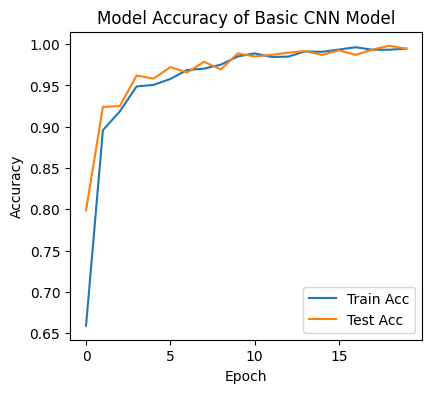

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Test Acc')
plt.title("Model Accuracy of Basic CNN Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Training Loss Vs Validation Loss

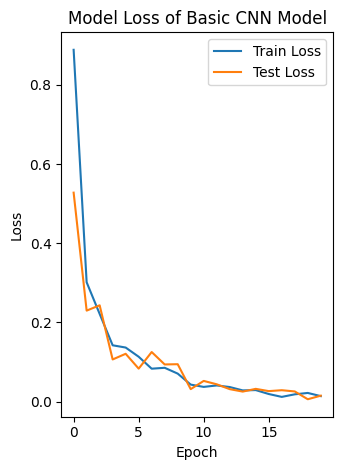

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Model Loss of Basic CNN Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Test Model with Unseen Data

In [ ]:
test_loss, test_acc = model_CNN.evaluate(test_data)
print(f"Test Accuracy of Basic CNN model: {test_acc:.4f}")
print(f"Test Loss of Basic CNN model: {test_loss:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 1.1902e-04
Test Accuracy of Basic CNN model: 1.0000
Test Loss of Basic CNN model: 0.0001


# Model Evaluation with Confusion Matrix and Classification Report

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

        next       1.00      1.00      1.00       300
       pause       1.00      1.00      1.00       300
        play       1.00      1.00      1.00       300
    previous       1.00      1.00      1.00       300
        stop       1.00      1.00      1.00       300
   volume_up       1.00      1.00      1.00       300

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



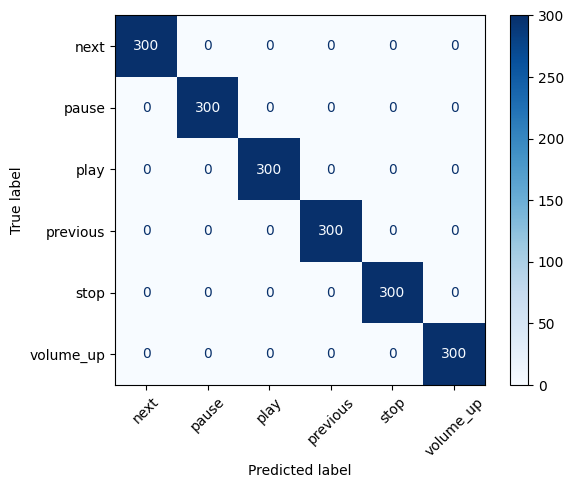

In [ ]:
# Predictions
Y_pred = model_CNN.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Save Model and Download Locally

In [ ]:
model_CNN.save('/content/gesture_CNN_model.h5')

In [ ]:
files.download("gesture_CNN_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Build Model with MobilenetV2 Architecture

In [ ]:

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base initially

model_mobilenet = Sequential([
    Conv2D(3, (3,3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),  # Convert grayscale to 3 channels
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Summary

In [ ]:
model_mobilenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,700 (8.64 MB)

 Trainable params: 7,716 (30.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Define Early Stoping and Learning Rate Reducer

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train Model

In [ ]:
history = model_mobilenet.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - accuracy: 0.6701 - loss: 0.9199 - val_accuracy: 0.9750 - val_loss: 0.1250 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 0.9764 - loss: 0.1126 - val_accuracy: 0.9806 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - accuracy: 0.9822 - loss: 0.0649 - val_accuracy: 0.9917 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.9858 - loss: 0.0526 - val_accuracy: 0.9907 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9920 - loss: 0.0342 - val_accuracy: 0.9889 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.9924 - loss: 0.0285 - val_accuracy: 0.9898 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.9

# Plot Model Accuracy

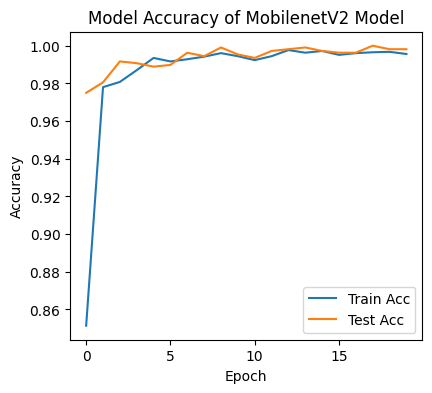

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Test Acc')
plt.title("Model Accuracy of MobilenetV2 Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Testing Vs Validation Loss

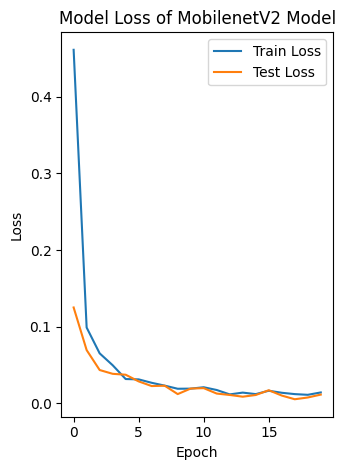

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Model Loss of MobilenetV2 Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Test Model with Unseen Data

In [ ]:
test_loss, test_acc = model_mobilenet.evaluate(test_data)
print(f"Test Accuracy using Transfer Learning (MobilenetV2): {test_acc:.4f}")
print(f"Test Loss using Transfer Learning (MobilenetV2): {test_loss:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 1.0000 - loss: 4.8399e-04
Test Accuracy using Transfer Learning (MobilenetV2): 1.0000
Test Loss using Transfer Learning (MobilenetV2): 0.0008


# Model Evaluation with Confusion Matrix and Classification Report

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step
              precision    recall  f1-score   support

        next       1.00      1.00      1.00       300
       pause       1.00      1.00      1.00       300
        play       1.00      1.00      1.00       300
    previous       1.00      1.00      1.00       300
        stop       1.00      1.00      1.00       300
   volume_up       1.00      1.00      1.00       300

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



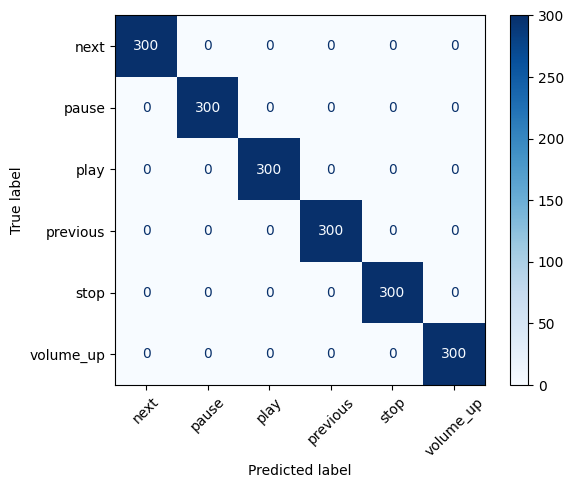

In [ ]:
# Predictions
Y_pred = model_mobilenet.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Save Model and Download Locally

In [ ]:
model_mobilenet.save('/content/gesture_MobilenetV2_model.h5')
files.download("gesture_MobilenetV2_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test Set Evaluation

The performance of both the baseline CNN model and the proposed MobileNetV2 model was evaluated on the withheld test dataset. The following results summarize the classification accuracy achieved by each model:

- **Baseline CNN Model Test Accuracy:** 99.81%
- **MobileNetV2 Model Test Accuracy:** 98–100%

Both models achieved high accuracy on the test dataset. However, real-time testing using webcam input demonstrated that the baseline CNN model failed to maintain stable and reliable gesture recognition. The model showed inconsistent predictions under variations in hand position, lighting, and gesture angles.

In contrast, the MobileNetV2 model provided consistent and accurate predictions during both offline testing and real-time deployment. The MobileNetV2 architecture, combined with the prediction buffer and majority voting mechanism, significantly improved the stability of real-time gesture recognition.